I'll study the reason why singularities occur when converting from quaternions to Euler angles, but not the other way around. The reference implementation used is from ROS's [tf package](https://github.com/ros/geometry), in [tf/src/tf/transformations.py](https://github.com/ros/geometry/blob/8a8a91d5eca12b7ff376b1b95f69563d87132c76/tf/src/tf/transformations.py).

Let's first import the packages we'll need.

In [62]:
import math

import matplotlib.pyplot as plt
%matplotlib inline

import numpy  # Used as such by `tf`
import numpy as np

import sympy as sm
from sympy.physics.quantum import TensorProduct

sm.init_printing()
x, y, z, w = sm.symbols("x y z w")

The five functions we'll look at are:

* `rotation_matrix()`, defined on [line 275](https://github.com/ros/geometry/blob/8a8a91d5eca12b7ff376b1b95f69563d87132c76/tf/src/tf/transformations.py#L275). It returns a matrix to rotate about axis defined by point and direction.
* `quaternion_matrix()`, definded on [line 1174](https://github.com/ros/geometry/blob/8a8a91d5eca12b7ff376b1b95f69563d87132c76/tf/src/tf/transformations.py#L1174). It returns a homogeneous rotation matrix from quaternion.
* `euler_from_matrix()`, defined on [line 1031](https://github.com/ros/geometry/blob/8a8a91d5eca12b7ff376b1b95f69563d87132c76/tf/src/tf/transformations.py#L1031). It returns Euler angles from rotation matrix for specified axis sequence.
* `euler_from_quaternion()`, defined on [line 1089](https://github.com/ros/geometry/blob/8a8a91d5eca12b7ff376b1b95f69563d87132c76/tf/src/tf/transformations.py#L1089). It returns Euler angles from quaternion for specified axis sequence.
* `quaternion_from_euler()`, defined on [line 1100](https://github.com/ros/geometry/blob/8a8a91d5eca12b7ff376b1b95f69563d87132c76/tf/src/tf/transformations.py#L1100). It returns a quaternion from Euler angles and axis sequence.

The input quaternions are all of the form $[x, y, z, w]$; the Euler angles are roll, pitch, and yaw; and the axis sequence is one of 24 axis sequences as string or encoded tuple, shown below:


In [2]:
_AXES2TUPLE = {
    'sxyz': (0, 0, 0, 0), 'sxyx': (0, 0, 1, 0), 'sxzy': (0, 1, 0, 0),
    'sxzx': (0, 1, 1, 0), 'syzx': (1, 0, 0, 0), 'syzy': (1, 0, 1, 0),
    'syxz': (1, 1, 0, 0), 'syxy': (1, 1, 1, 0), 'szxy': (2, 0, 0, 0),
    'szxz': (2, 0, 1, 0), 'szyx': (2, 1, 0, 0), 'szyz': (2, 1, 1, 0),
    'rzyx': (0, 0, 0, 1), 'rxyx': (0, 0, 1, 1), 'ryzx': (0, 1, 0, 1),
    'rxzx': (0, 1, 1, 1), 'rxzy': (1, 0, 0, 1), 'ryzy': (1, 0, 1, 1),
    'rzxy': (1, 1, 0, 1), 'ryxy': (1, 1, 1, 1), 'ryxz': (2, 0, 0, 1),
    'rzxz': (2, 0, 1, 1), 'rxyz': (2, 1, 0, 1), 'rzyz': (2, 1, 1, 1)}

The tuple contents are inner axis, parity, repetition, then frame. Two other helper variables are `_NEXT_AXIS` and `_EPS`

In [5]:
_NEXT_AXIS = [1, 2, 0, 1] # axis sequences for Euler angles
_EPS = numpy.finfo(float).eps * 4.0  # epsilon for testing whether a number is close to zero

Let's first import the packages we'll need.


# `quaternion_from_euler()`

In [14]:
def quaternion_from_euler(ai, aj, ak, axes='sxyz'):
    """Return quaternion from Euler angles and axis sequence.
    ai, aj, ak : Euler's roll, pitch and yaw angles
    axes : One of 24 axis sequences as string or encoded tuple
    >>> q = quaternion_from_euler(1, 2, 3, 'ryxz')
    >>> numpy.allclose(q, [0.310622, -0.718287, 0.444435, 0.435953])
    True
    
    """
    try:
        firstaxis, parity, repetition, frame = _AXES2TUPLE[axes.lower()]
    except (AttributeError, KeyError):
        _ = _TUPLE2AXES[axes]
        firstaxis, parity, repetition, frame = axes

    i = firstaxis
    j = _NEXT_AXIS[i+parity]
    k = _NEXT_AXIS[i-parity+1]

    if frame:
        ai, ak = ak, ai
    if parity:
        aj = -aj

    ai /= 2.0
    aj /= 2.0
    ak /= 2.0
    ci = math.cos(ai)
    si = math.sin(ai)
    cj = math.cos(aj)
    sj = math.sin(aj)
    ck = math.cos(ak)
    sk = math.sin(ak)
    cc = ci*ck
    cs = ci*sk
    sc = si*ck
    ss = si*sk

    quaternion = numpy.empty((4, ), dtype=numpy.float64)
    if repetition:
        quaternion[i] = cj*(cs + sc)
        quaternion[j] = sj*(cc + ss)
        quaternion[k] = sj*(cs - sc)
        quaternion[3] = cj*(cc - ss)
    else:
        quaternion[i] = cj*sc - sj*cs
        quaternion[j] = cj*ss + sj*cc
        quaternion[k] = cj*cs - sj*sc
        quaternion[3] = cj*cc + sj*ss
    if parity:
        quaternion[j] *= -1

    return quaternion

We know that singularities are caused by certain values approaching infinity. This usually happens with division by zero, or with a function with an asymptotic range. None of the mathematical operations in `quaternion_from_euler()` cause a singularity, while the functions are $\cos$ and $\sin$.

Let's plot their graphs, in radians. First, we define the range of input angles we're interested in. Since we're using radians, we can plot from $-\pi$ to $\pi$.

In [15]:
angles = np.linspace(-np.pi, np.pi)

Let's look at the cosine and sine curves.

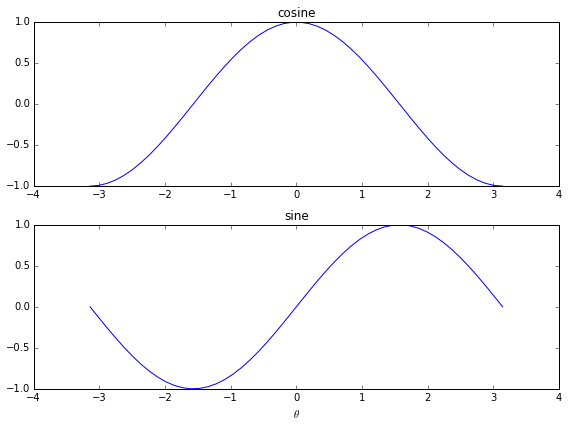

In [124]:
fig = plt.figure()
ax_cos = fig.add_subplot(2, 1, 1)
ax_cos.plot(angles, np.cos(angles))
ax_cos.set_title("cosine")
ax_sin = fig.add_subplot(2, 1, 2)
ax_sin.plot(angles, np.sin(angles))
ax_sin.set_title("sine")
ax_sin.set_xlabel("$θ$")
plt.tight_layout()

In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')


As we can see, the ranges of sine and cosine are always between -1 and 1. Since the divisions are with nonzero constants, it is clear that `quaternion_from_euler()` can cause no singularities, no matter the inputs.

# `euler_from_quaternion()`

`euler_from_quaternion()` simply calls `euler_from_matrix()` using a quaternion matrix. This is the function that is known to cause singularities.

In [17]:
def euler_from_quaternion(quaternion, axes='sxyz'):
    """Return Euler angles from quaternion for specified axis sequence.
    >>> angles = euler_from_quaternion([0.06146124, 0, 0, 0.99810947])
    >>> numpy.allclose(angles, [0.123, 0, 0])
    True

    """
    return euler_from_matrix(quaternion_matrix(quaternion), axes)

## `quaternion_matrix()`

In [18]:
def quaternion_matrix(quaternion):
    """Return homogeneous rotation matrix from quaternion.
    >>> R = quaternion_matrix([0.06146124, 0, 0, 0.99810947])
    >>> numpy.allclose(R, rotation_matrix(0.123, (1, 0, 0)))
    True
    
    """
    q = numpy.array(quaternion[:4], dtype=numpy.float64, copy=True)
    nq = numpy.dot(q, q)
    if nq < _EPS:
        return numpy.identity(4)
    q *= math.sqrt(2.0 / nq)
    q = numpy.outer(q, q)
    return numpy.array((
        (1.0-q[1, 1]-q[2, 2],     q[0, 1]-q[2, 3],     q[0, 2]+q[1, 3], 0.0),
        (    q[0, 1]+q[2, 3], 1.0-q[0, 0]-q[2, 2],     q[1, 2]-q[0, 3], 0.0),
        (    q[0, 2]-q[1, 3],     q[1, 2]+q[0, 3], 1.0-q[0, 0]-q[1, 1], 0.0),
        (                0.0,                 0.0,                 0.0, 1.0)
        ), dtype=numpy.float64)

`nq` is the dot product of the quaternion by itself, which is the square of the length. If that length is zero, then an identity matrix is returned. If it is not zero, the quaternion is normalized to a length of $\sqrt{2}$ and manipulated with addition, subtraction, and multiplication. The singularity does not come from here.

These are the contents of the matrix.

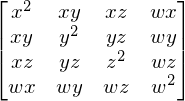

In [19]:
q = sm.Matrix([[x, y, z, w]])  # Assume already normalized to sqrt(2) length
M = TensorProduct(q, q.T)
M

## `euler_from_matrix()`

In [20]:
def euler_from_matrix(matrix, axes='sxyz'):
    """Return Euler angles from rotation matrix for specified axis sequence.
    axes : One of 24 axis sequences as string or encoded tuple
    Note that many Euler angle triplets can describe one matrix.
    >>> R0 = euler_matrix(1, 2, 3, 'syxz')
    >>> al, be, ga = euler_from_matrix(R0, 'syxz')
    >>> R1 = euler_matrix(al, be, ga, 'syxz')
    >>> numpy.allclose(R0, R1)
    True
    >>> angles = (4.0*math.pi) * (numpy.random.random(3) - 0.5)
    >>> for axes in _AXES2TUPLE.keys():
    ...    R0 = euler_matrix(axes=axes, *angles)
    ...    R1 = euler_matrix(axes=axes, *euler_from_matrix(R0, axes))
    ...    if not numpy.allclose(R0, R1): print(axes, "failed")
    
    """
    try:
        firstaxis, parity, repetition, frame = _AXES2TUPLE[axes.lower()]
    except (AttributeError, KeyError):
        _ = _TUPLE2AXES[axes]
        firstaxis, parity, repetition, frame = axes

    i = firstaxis
    j = _NEXT_AXIS[i+parity]
    k = _NEXT_AXIS[i-parity+1]

    M = numpy.array(matrix, dtype=numpy.float64, copy=False)[:3, :3]
    if repetition:
        sy = math.sqrt(M[i, j]*M[i, j] + M[i, k]*M[i, k])
        if sy > _EPS:
            ax = math.atan2( M[i, j],  M[i, k])
            ay = math.atan2( sy,       M[i, i])
            az = math.atan2( M[j, i], -M[k, i])
        else:
            ax = math.atan2(-M[j, k],  M[j, j])
            ay = math.atan2( sy,       M[i, i])
            az = 0.0
    else:
        cy = math.sqrt(M[i, i]*M[i, i] + M[j, i]*M[j, i])
        if cy > _EPS:
            ax = math.atan2( M[k, j],  M[k, k])
            ay = math.atan2(-M[k, i],  cy)
            az = math.atan2( M[j, i],  M[i, i])
        else:
            ax = math.atan2(-M[j, k],  M[j, j])
            ay = math.atan2(-M[k, i],  cy)
            az = 0.0

    if parity:
        ax, ay, az = -ax, -ay, -az
    if frame:
        ax, az = az, ax
    return ax, ay, az

This function has to use $\arctan$ in order to computer the Euler angles. Let's look at the output of arctan given different inputs.

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


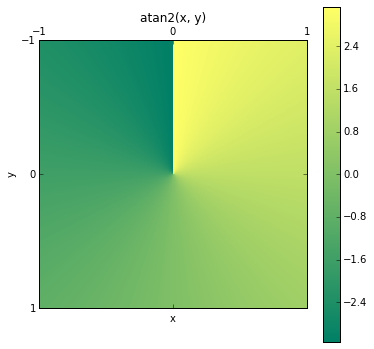

In [101]:
xs = np.linspace(-1, 1, num=500)
ys = np.linspace(-1, 1, num=500)
xx, yy = np.meshgrid(xs, ys)

z = np.arctan2(xx, yy)
plt.matshow(z, extent=(xs.min(), xs.max(), ys.max(), ys.min()))
plt.title("atan2(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.set_cmap("summer")

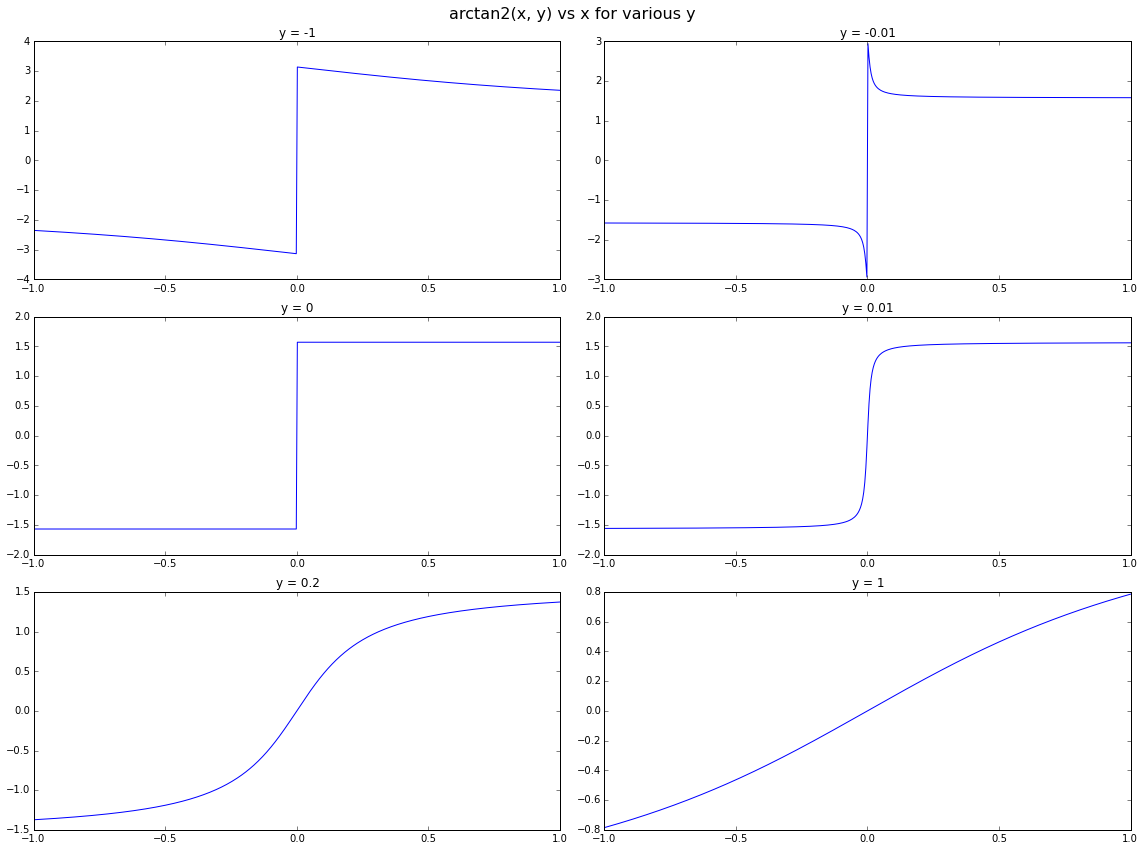

In [142]:
plt.rcParams["figure.figsize"] = 16, 12
fig = plt.figure()
fig.suptitle("arctan2(x, y) vs x for various y", fontsize=16)
for i, y_val in enumerate((-1, -1e-2, 0, 1e-2, 0.2, 1)):
    ax = fig.add_subplot(3, 2, i + 1)
    ax.plot(xs, np.arctan2(xs, y_val))
    ax.set_title("y = {}".format(y_val))
plt.tight_layout()
plt.subplots_adjust(top=.94)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

We can clearly see the discontinuity when $x$ is close to zero and $y$ is negative. The value jumps instantaneously from $-\pi$ to $\pi$ between a negative and positive $x$. When $y$ is close to zero, there is a continuous jump. To see where this happens in a quaternion to Euler angle transformation, we notice that `euler_from_quaternion()` uses the "sxyz" axis.

In [22]:
_AXES2TUPLE["sxyz"]  # inner axis, parity, repetition, frame

The first axis is \#0, there is no parity or repetition, and the frame is \#0. We can use that information to simplify the `euler_from_matrix()` function.

In [153]:
def euler_from_matrix_simplified(matrix):
    i = 0
    j = _NEXT_AXIS[0]
    k = _NEXT_AXIS[1]

    M = numpy.array(matrix, dtype=numpy.float64, copy=False)[:3, :3]

    cy = math.sqrt(M[i, i]*M[i, i] + M[j, i]*M[j, i])
    if cy > _EPS:
        ax = math.atan2( M[k, j],  M[k, k])
        ay = math.atan2(-M[k, i],  cy)
        az = math.atan2( M[j, i],  M[i, i])
    else:
        ax = math.atan2(-M[j, k],  M[j, j])
        ay = math.atan2(-M[k, i],  cy)
        az = 0.0

    return ax, ay, az

The axes used are:

In [154]:
i, j, k = 0, _NEXT_AXIS[0], _NEXT_AXIS[1]
print(i, j, k)

0 1 2


With `euler_from_quaternion()`, `M` is a 4x4 matrix, shown below.

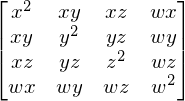

In [155]:
M

The first term of the arctangent can be zero if any of `M[k, j]`, `M[k, i]`, `M[j, i]`, or `M[j, k]` is zero.

In [156]:
print(M[k, j], M[k, i], M[j, i], M[j, k])

y*z x*z x*y y*z


In other words, if any of the x, y, and z components of the quaternion is zero, then the Euler angle will have a singularity if the second term is negative or small. However, since all second terms are either squares or sums of squares, none of them can be neagative.

In [157]:
print(M[i, i], M[j, j], M[k, k], sm.sqrt(M[i, i]*M[i, i] + M[j, i]*M[j, i]))

x**2 y**2 z**2 sqrt(x**4 + x**2*y**2)


So, the jump occurs if at least one of the x, y, and z components is approximately zero, and another is zero or a small positive. The relationship is shown in the following table.

| $\approx 0$ |       small positive or zero |
|-------------|-----------------------------:|
| $yz$        | $z^2$ (if `cy` > 0) or $y^2$ |
| $xz$        |        $\sqrt{x^4 + x^2y^2}$ |
| $xy$        |                        $x^2$ |

Note that the second term being zero only yields a jump if the first term is not exactly equal to zero. This is because `np.arctan2(0, 0)` is defined as 0.

# Angles between quaternions

The functions I'm using are:

In [194]:
def unit_vector(v):
    """
    Change the length of the vector to unity in the same direction.

    Parameters
    ----------
    v : np.ndarray
        A vector to be normalized.

    Returns
    -------
    np.ndarray
        The normalized vector, or the original vector if it has a length of 0.

    """
    norm = np.linalg.norm(v)
    if norm:
        return v / norm
    else:
        return np.asarray(v)

    
def angle_between(a, b):
    """
    Find the angle between two vectors.

    Parameters
    ----------
    a : Sequence[float]
        A vector of length n.
    b : Sequence[float]
        A vector of length n.

    Returns
    -------
    float
        The angle between the quaternions, in radians.

    Raises
    ------
    ValueError
        If the lengths of the vectors are different.

    Examples
    --------
    >>> angle_between([1, 0, 0], [0, 1, 0])
    1.5707963267948966
    >>> angle_between([1, 0, 0], [1, 0, 0])
    0.0
    >>> angle_between([1, 0, 0], [-1, 0, 0])
    3.1415926535897931

    """
    return np.arccos(np.clip(np.dot(unit_vector(a), unit_vector(b)), -1, 1))


def angle_between_quaternions(a, b):
    """
    Find the angle between two quaternions.

    Parameters
    ----------
    a : Sequence[float]
        A quaternion in the order of x, y, z, w.
    b : Sequence[float]
        A quaternion in the order of x, y, z, w.

    Returns
    -------
    float
        The angle between the quaternions, in radians.

    Examples
    --------
    >>> angle_between_quaternions([0, 0, 0, 1], [0, 0, 0, 1])
    0.0
    >>> angle_between_quaternions([0, 0, 0, 1], [0, -1, 0, 1])
    1.5707963267948968

    """
    return 2 * angle_between(a, b)

For a roll, yaw, pitch order, a drone pointing east with body level, and one pointing east with body perpendicular to the ground, would have an angle of 90 degrees.

In [176]:
np.rad2deg(angle_between_quaternions(quaternion_from_euler(*np.deg2rad([0, 90, 0])),
                                     quaternion_from_euler(*np.deg2rad([90, 0, 90]))))

The same thing happens when the drone points north with body level.

In [177]:
np.rad2deg(angle_between_quaternions(quaternion_from_euler(*np.deg2rad([0, 90, 0])),
                                     quaternion_from_euler(*np.deg2rad([0, 0, 0]))))

However, when the drone is pointing north with body perpendicular, we get 120 degrees, but I do not understand why.

In [202]:
np.rad2deg(angle_between_quaternions(quaternion_from_euler(*np.deg2rad([0, 90, 0])),
                                     quaternion_from_euler(*np.deg2rad([90, 0, 0]))))

In [233]:
np.rad2deg(angle_between_quaternions(quaternion_from_euler(*np.deg2rad([0, 0, 0])),
                                     quaternion_from_euler(*np.deg2rad([45, 0, 45]))))

The angle between quaternions is equal to 90 iff both pitch and roll are equal.

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


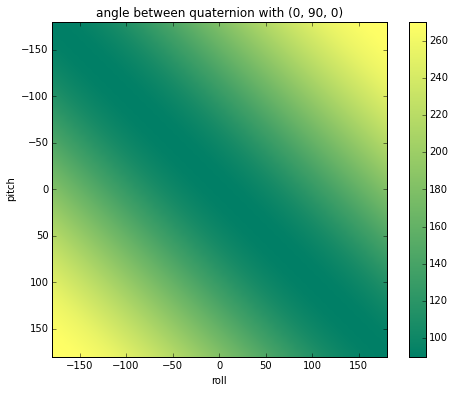

In [227]:
rolls = np.linspace(-np.pi, np.pi)
pitches = np.linspace(-np.pi, np.pi)

z = np.array([angle_between_quaternions(quaternion_from_euler(0, np.pi/2, 0),
                                        quaternion_from_euler(roll, 0, pitch))
              for roll in rolls for pitch in pitches]).reshape(len(rolls), len(pitches))
plt.imshow(np.rad2deg(z),
           extent=np.rad2deg([rolls.min(), rolls.max(),
                              pitches.max(), pitches.min()]))
plt.colorbar()
plt.xlabel("roll")
plt.ylabel("pitch")
plt.title("angle between quaternion with (0, 90, 0)")
plt.set_cmap("summer")

# Functions used in doctests

Do not run unless you need to run the doctests.

In [ ]:
def euler_matrix(ai, aj, ak, axes='sxyz'):
    """Return homogeneous rotation matrix from Euler angles and axis sequence.
    ai, aj, ak : Euler's roll, pitch and yaw angles
    axes : One of 24 axis sequences as string or encoded tuple
    >>> R = euler_matrix(1, 2, 3, 'syxz')
    >>> numpy.allclose(numpy.sum(R[0]), -1.34786452)
    True
    >>> R = euler_matrix(1, 2, 3, (0, 1, 0, 1))
    >>> numpy.allclose(numpy.sum(R[0]), -0.383436184)
    True
    >>> ai, aj, ak = (4.0*math.pi) * (numpy.random.random(3) - 0.5)
    >>> for axes in _AXES2TUPLE.keys():
    ...    R = euler_matrix(ai, aj, ak, axes)
    >>> for axes in _TUPLE2AXES.keys():
    ...    R = euler_matrix(ai, aj, ak, axes)
    """
    try:
        firstaxis, parity, repetition, frame = _AXES2TUPLE[axes]
    except (AttributeError, KeyError):
        _ = _TUPLE2AXES[axes]
        firstaxis, parity, repetition, frame = axes

    i = firstaxis
    j = _NEXT_AXIS[i+parity]
    k = _NEXT_AXIS[i-parity+1]

    if frame:
        ai, ak = ak, ai
    if parity:
        ai, aj, ak = -ai, -aj, -ak

    si, sj, sk = math.sin(ai), math.sin(aj), math.sin(ak)
    ci, cj, ck = math.cos(ai), math.cos(aj), math.cos(ak)
    cc, cs = ci*ck, ci*sk
    sc, ss = si*ck, si*sk

    M = numpy.identity(4)
    if repetition:
        M[i, i] = cj
        M[i, j] = sj*si
        M[i, k] = sj*ci
        M[j, i] = sj*sk
        M[j, j] = -cj*ss+cc
        M[j, k] = -cj*cs-sc
        M[k, i] = -sj*ck
        M[k, j] = cj*sc+cs
        M[k, k] = cj*cc-ss
    else:
        M[i, i] = cj*ck
        M[i, j] = sj*sc-cs
        M[i, k] = sj*cc+ss
        M[j, i] = cj*sk
        M[j, j] = sj*ss+cc
        M[j, k] = sj*cs-sc
        M[k, i] = -sj
        M[k, j] = cj*si
        M[k, k] = cj*ci
    return M

def unit_vector(data, axis=None, out=None):
    """Return ndarray normalized by length, i.e. eucledian norm, along axis.
    >>> v0 = numpy.random.random(3)
    >>> v1 = unit_vector(v0)
    >>> numpy.allclose(v1, v0 / numpy.linalg.norm(v0))
    True
    >>> v0 = numpy.random.rand(5, 4, 3)
    >>> v1 = unit_vector(v0, axis=-1)
    >>> v2 = v0 / numpy.expand_dims(numpy.sqrt(numpy.sum(v0*v0, axis=2)), 2)
    >>> numpy.allclose(v1, v2)
    True
    >>> v1 = unit_vector(v0, axis=1)
    >>> v2 = v0 / numpy.expand_dims(numpy.sqrt(numpy.sum(v0*v0, axis=1)), 1)
    >>> numpy.allclose(v1, v2)
    True
    >>> v1 = numpy.empty((5, 4, 3), dtype=numpy.float64)
    >>> unit_vector(v0, axis=1, out=v1)
    >>> numpy.allclose(v1, v2)
    True
    >>> list(unit_vector([]))
    []
    >>> list(unit_vector([1.0]))
    [1.0]
    """
    if out is None:
        data = numpy.array(data, dtype=numpy.float64, copy=True)
        if data.ndim == 1:
            data /= math.sqrt(numpy.dot(data, data))
            return data
    else:
        if out is not data:
            out[:] = numpy.array(data, copy=False)
        data = out
    length = numpy.atleast_1d(numpy.sum(data*data, axis))
    numpy.sqrt(length, length)
    if axis is not None:
        length = numpy.expand_dims(length, axis)
    data /= length
    if out is None:
        return data
    
def rotation_matrix(angle, direction, point=None):
    """Return matrix to rotate about axis defined by point and direction.
    >>> angle = (random.random() - 0.5) * (2*math.pi)
    >>> direc = numpy.random.random(3) - 0.5
    >>> point = numpy.random.random(3) - 0.5
    >>> R0 = rotation_matrix(angle, direc, point)
    >>> R1 = rotation_matrix(angle-2*math.pi, direc, point)
    >>> is_same_transform(R0, R1)
    True
    >>> R0 = rotation_matrix(angle, direc, point)
    >>> R1 = rotation_matrix(-angle, -direc, point)
    >>> is_same_transform(R0, R1)
    True
    >>> I = numpy.identity(4, numpy.float64)
    >>> numpy.allclose(I, rotation_matrix(math.pi*2, direc))
    True
    >>> numpy.allclose(2., numpy.trace(rotation_matrix(math.pi/2,
    ...                                                direc, point)))
    True
    
    """
    sina = math.sin(angle)
    cosa = math.cos(angle)
    direction = unit_vector(direction[:3])
    # rotation matrix around unit vector
    R = numpy.array(((cosa, 0.0,  0.0),
                     (0.0,  cosa, 0.0),
                     (0.0,  0.0,  cosa)), dtype=numpy.float64)
    R += numpy.outer(direction, direction) * (1.0 - cosa)
    direction *= sina
    R += numpy.array((( 0.0,         -direction[2],  direction[1]),
                      ( direction[2], 0.0,          -direction[0]),
                      (-direction[1], direction[0],  0.0)),
                     dtype=numpy.float64)
    M = numpy.identity(4)
    M[:3, :3] = R
    if point is not None:
        # rotation not around origin
        point = numpy.array(point[:3], dtype=numpy.float64, copy=False)
        M[:3, 3] = point - numpy.dot(R, point)
    return M